# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 5, 5, 5, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=5, out_features=5, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=5, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 5, 5, 5, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 1.1526
Epoch 1/200, Iteration 2/12, Loss: 1.1277
Epoch 1/200, Iteration 3/12, Loss: 1.0614
Epoch 1/200, Iteration 4/12, Loss: 0.9742
Epoch 1/200, Iteration 5/12, Loss: 1.0817
Epoch 1/200, Iteration 6/12, Loss: 1.1586
Epoch 1/200, Iteration 7/12, Loss: 1.0861
Epoch 1/200, Iteration 8/12, Loss: 1.0417
Epoch 1/200, Iteration 9/12, Loss: 0.8792
Epoch 1/200, Iteration 10/12, Loss: 1.2175
Epoch 1/200, Iteration 11/12, Loss: 0.8251
Epoch 1/200, Iteration 12/12, Loss: 0.8484
Epoch 1/200, Iteration 13/12, Loss: 1.3461
Train Error: 
 Accuracy: 38.75%, Avg loss: 0.969828, MRE: 0.738376, MAE: 0.111815 

Test Error: 
 Accuracy: 41.0%, Avg loss: 0.877931, MRE: 0.604229, MAE: 0.100850 

Epoch 2/200, Iteration 1/12, Loss: 1.0631
Epoch 2/200, Iteration 2/12, Loss: 0.8100
Epoch 2/200, Iteration 3/12, Loss: 1.0578
Epoch 2/200, Iteration 4/12, Loss: 0.7473
Epoch 2/200, Iteration 5/12, Loss: 1.1137
Epoch 2/200, Iteration 6/12, Loss: 0.9957
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 87.88%, Avg loss: 0.030576, MRE: 0.084250, MAE: 0.017763 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.025165, MRE: 0.074866, MAE: 0.017089 

Epoch 13/200, Iteration 1/12, Loss: 0.0291
Epoch 13/200, Iteration 2/12, Loss: 0.0265
Epoch 13/200, Iteration 3/12, Loss: 0.0188
Epoch 13/200, Iteration 4/12, Loss: 0.0382
Epoch 13/200, Iteration 5/12, Loss: 0.0329
Epoch 13/200, Iteration 6/12, Loss: 0.0232
Epoch 13/200, Iteration 7/12, Loss: 0.0477
Epoch 13/200, Iteration 8/12, Loss: 0.0256
Epoch 13/200, Iteration 9/12, Loss: 0.0255
Epoch 13/200, Iteration 10/12, Loss: 0.0345
Epoch 13/200, Iteration 11/12, Loss: 0.0272
Epoch 13/200, Iteration 12/12, Loss: 0.0314
Epoch 13/200, Iteration 13/12, Loss: 0.0179
Train Error: 
 Accuracy: 85.88%, Avg loss: 0.027217, MRE: 0.081068, MAE: 0.017303 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.026655, MRE: 0.074288, MAE: 0.017529 

Epoch 14/200, Iteration 1/12, Loss: 0.0191
Epoch 14/200, Iteration 2/12, Loss: 0.0263
Epoch 14/200, Itera

Epoch 25/200, Iteration 13/12, Loss: 0.0132
Train Error: 
 Accuracy: 80.12%, Avg loss: 0.013031, MRE: 0.052019, MAE: 0.009551 

Test Error: 
 Accuracy: 81.5%, Avg loss: 0.008357, MRE: 0.044823, MAE: 0.008529 

Epoch 26/200, Iteration 1/12, Loss: 0.0075
Epoch 26/200, Iteration 2/12, Loss: 0.0236
Epoch 26/200, Iteration 3/12, Loss: 0.0081
Epoch 26/200, Iteration 4/12, Loss: 0.0115
Epoch 26/200, Iteration 5/12, Loss: 0.0077
Epoch 26/200, Iteration 6/12, Loss: 0.0167
Epoch 26/200, Iteration 7/12, Loss: 0.0106
Epoch 26/200, Iteration 8/12, Loss: 0.0149
Epoch 26/200, Iteration 9/12, Loss: 0.0154
Epoch 26/200, Iteration 10/12, Loss: 0.0084
Epoch 26/200, Iteration 11/12, Loss: 0.0093
Epoch 26/200, Iteration 12/12, Loss: 0.0150
Epoch 26/200, Iteration 13/12, Loss: 0.0058
Train Error: 
 Accuracy: 91.25%, Avg loss: 0.010563, MRE: 0.047415, MAE: 0.008843 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.008844, MRE: 0.042629, MAE: 0.008179 

Epoch 27/200, Iteration 1/12, Loss: 0.0056
Epoch 27/200, Iter

Train Error: 
 Accuracy: 92.0%, Avg loss: 0.006863, MRE: 0.041448, MAE: 0.006736 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.004124, MRE: 0.031346, MAE: 0.005619 

Epoch 38/200, Iteration 1/12, Loss: 0.0083
Epoch 38/200, Iteration 2/12, Loss: 0.0098
Epoch 38/200, Iteration 3/12, Loss: 0.0079
Epoch 38/200, Iteration 4/12, Loss: 0.0055
Epoch 38/200, Iteration 5/12, Loss: 0.0067
Epoch 38/200, Iteration 6/12, Loss: 0.0054
Epoch 38/200, Iteration 7/12, Loss: 0.0113
Epoch 38/200, Iteration 8/12, Loss: 0.0085
Epoch 38/200, Iteration 9/12, Loss: 0.0058
Epoch 38/200, Iteration 10/12, Loss: 0.0059
Epoch 38/200, Iteration 11/12, Loss: 0.0053
Epoch 38/200, Iteration 12/12, Loss: 0.0056
Epoch 38/200, Iteration 13/12, Loss: 0.0062
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.007137, MRE: 0.041431, MAE: 0.007029 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.006914, MRE: 0.034223, MAE: 0.007054 

Epoch 39/200, Iteration 1/12, Loss: 0.0057
Epoch 39/200, Iteration 2/12, Loss: 0.0130
Epoch 39/200, Iterat

Train Error: 
 Accuracy: 94.62%, Avg loss: 0.005128, MRE: 0.036023, MAE: 0.006453 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.003760, MRE: 0.027892, MAE: 0.005612 

Epoch 50/200, Iteration 1/12, Loss: 0.0032
Epoch 50/200, Iteration 2/12, Loss: 0.0065
Epoch 50/200, Iteration 3/12, Loss: 0.0044
Epoch 50/200, Iteration 4/12, Loss: 0.0048
Epoch 50/200, Iteration 5/12, Loss: 0.0057
Epoch 50/200, Iteration 6/12, Loss: 0.0029
Epoch 50/200, Iteration 7/12, Loss: 0.0050
Epoch 50/200, Iteration 8/12, Loss: 0.0025
Epoch 50/200, Iteration 9/12, Loss: 0.0070
Epoch 50/200, Iteration 10/12, Loss: 0.0037
Epoch 50/200, Iteration 11/12, Loss: 0.0045
Epoch 50/200, Iteration 12/12, Loss: 0.0093
Epoch 50/200, Iteration 13/12, Loss: 0.0086
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.005703, MRE: 0.037452, MAE: 0.006349 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.005842, MRE: 0.031162, MAE: 0.006256 

Epoch 51/200, Iteration 1/12, Loss: 0.0081
Epoch 51/200, Iteration 2/12, Loss: 0.0024
Epoch 51/200, Itera

Train Error: 
 Accuracy: 81.38%, Avg loss: 0.005743, MRE: 0.035980, MAE: 0.006658 

Test Error: 
 Accuracy: 84.0%, Avg loss: 0.005244, MRE: 0.030978, MAE: 0.006570 

Epoch 62/200, Iteration 1/12, Loss: 0.0050
Epoch 62/200, Iteration 2/12, Loss: 0.0070
Epoch 62/200, Iteration 3/12, Loss: 0.0028
Epoch 62/200, Iteration 4/12, Loss: 0.0065
Epoch 62/200, Iteration 5/12, Loss: 0.0066
Epoch 62/200, Iteration 6/12, Loss: 0.0029
Epoch 62/200, Iteration 7/12, Loss: 0.0060
Epoch 62/200, Iteration 8/12, Loss: 0.0032
Epoch 62/200, Iteration 9/12, Loss: 0.0029
Epoch 62/200, Iteration 10/12, Loss: 0.0025
Epoch 62/200, Iteration 11/12, Loss: 0.0033
Epoch 62/200, Iteration 12/12, Loss: 0.0054
Epoch 62/200, Iteration 13/12, Loss: 0.0038
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.003950, MRE: 0.031463, MAE: 0.005271 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.002700, MRE: 0.024759, MAE: 0.004748 

Epoch 63/200, Iteration 1/12, Loss: 0.0025
Epoch 63/200, Iteration 2/12, Loss: 0.0021
Epoch 63/200, Iterat

Epoch 73/200, Iteration 13/12, Loss: 0.0051
Train Error: 
 Accuracy: 92.75%, Avg loss: 0.004368, MRE: 0.033337, MAE: 0.006023 

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.004185, MRE: 0.027619, MAE: 0.005734 

Epoch 74/200, Iteration 1/12, Loss: 0.0037
Epoch 74/200, Iteration 2/12, Loss: 0.0043
Epoch 74/200, Iteration 3/12, Loss: 0.0037
Epoch 74/200, Iteration 4/12, Loss: 0.0041
Epoch 74/200, Iteration 5/12, Loss: 0.0038
Epoch 74/200, Iteration 6/12, Loss: 0.0045
Epoch 74/200, Iteration 7/12, Loss: 0.0044
Epoch 74/200, Iteration 8/12, Loss: 0.0028
Epoch 74/200, Iteration 9/12, Loss: 0.0025
Epoch 74/200, Iteration 10/12, Loss: 0.0050
Epoch 74/200, Iteration 11/12, Loss: 0.0034
Epoch 74/200, Iteration 12/12, Loss: 0.0040
Epoch 74/200, Iteration 13/12, Loss: 0.0035
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.003363, MRE: 0.029700, MAE: 0.005046 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.003132, MRE: 0.024984, MAE: 0.004797 

Epoch 75/200, Iteration 1/12, Loss: 0.0032
Epoch 75/200, Itera

Train Error: 
 Accuracy: 97.88%, Avg loss: 0.003098, MRE: 0.029911, MAE: 0.005536 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002688, MRE: 0.022821, MAE: 0.005109 

Epoch 87/200, Iteration 1/12, Loss: 0.0028
Epoch 87/200, Iteration 2/12, Loss: 0.0034
Epoch 87/200, Iteration 3/12, Loss: 0.0026
Epoch 87/200, Iteration 4/12, Loss: 0.0041
Epoch 87/200, Iteration 5/12, Loss: 0.0038
Epoch 87/200, Iteration 6/12, Loss: 0.0024
Epoch 87/200, Iteration 7/12, Loss: 0.0044
Epoch 87/200, Iteration 8/12, Loss: 0.0025
Epoch 87/200, Iteration 9/12, Loss: 0.0026
Epoch 87/200, Iteration 10/12, Loss: 0.0026
Epoch 87/200, Iteration 11/12, Loss: 0.0022
Epoch 87/200, Iteration 12/12, Loss: 0.0028
Epoch 87/200, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 97.75%, Avg loss: 0.002862, MRE: 0.028515, MAE: 0.005149 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.002567, MRE: 0.022130, MAE: 0.004897 

Epoch 88/200, Iteration 1/12, Loss: 0.0024
Epoch 88/200, Iteration 2/12, Loss: 0.0019
Epoch 88/200, Itera

Epoch 98/200, Iteration 11/12, Loss: 0.0024
Epoch 98/200, Iteration 12/12, Loss: 0.0031
Epoch 98/200, Iteration 13/12, Loss: 0.0043
Train Error: 
 Accuracy: 98.62%, Avg loss: 0.003200, MRE: 0.028423, MAE: 0.005010 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002936, MRE: 0.022385, MAE: 0.004444 

Epoch 99/200, Iteration 1/12, Loss: 0.0052
Epoch 99/200, Iteration 2/12, Loss: 0.0023
Epoch 99/200, Iteration 3/12, Loss: 0.0028
Epoch 99/200, Iteration 4/12, Loss: 0.0033
Epoch 99/200, Iteration 5/12, Loss: 0.0035
Epoch 99/200, Iteration 6/12, Loss: 0.0040
Epoch 99/200, Iteration 7/12, Loss: 0.0023
Epoch 99/200, Iteration 8/12, Loss: 0.0047
Epoch 99/200, Iteration 9/12, Loss: 0.0039
Epoch 99/200, Iteration 10/12, Loss: 0.0033
Epoch 99/200, Iteration 11/12, Loss: 0.0039
Epoch 99/200, Iteration 12/12, Loss: 0.0019
Epoch 99/200, Iteration 13/12, Loss: 0.0026
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.003282, MRE: 0.028954, MAE: 0.005124 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003210, MRE:

Epoch 110/200, Iteration 13/12, Loss: 0.0021
Train Error: 
 Accuracy: 95.12%, Avg loss: 0.002714, MRE: 0.028090, MAE: 0.004713 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.002489, MRE: 0.022937, MAE: 0.004524 

Epoch 111/200, Iteration 1/12, Loss: 0.0028
Epoch 111/200, Iteration 2/12, Loss: 0.0036
Epoch 111/200, Iteration 3/12, Loss: 0.0029
Epoch 111/200, Iteration 4/12, Loss: 0.0023
Epoch 111/200, Iteration 5/12, Loss: 0.0016
Epoch 111/200, Iteration 6/12, Loss: 0.0020
Epoch 111/200, Iteration 7/12, Loss: 0.0018
Epoch 111/200, Iteration 8/12, Loss: 0.0022
Epoch 111/200, Iteration 9/12, Loss: 0.0024
Epoch 111/200, Iteration 10/12, Loss: 0.0037
Epoch 111/200, Iteration 11/12, Loss: 0.0025
Epoch 111/200, Iteration 12/12, Loss: 0.0036
Epoch 111/200, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.002380, MRE: 0.026500, MAE: 0.004422 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.002195, MRE: 0.020552, MAE: 0.003969 

Epoch 112/200, Iteration 1/12, Loss: 0.0019
Epo

Epoch 122/200, Iteration 12/12, Loss: 0.0026
Epoch 122/200, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.002424, MRE: 0.027511, MAE: 0.004581 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.002109, MRE: 0.020489, MAE: 0.003983 

Epoch 123/200, Iteration 1/12, Loss: 0.0018
Epoch 123/200, Iteration 2/12, Loss: 0.0028
Epoch 123/200, Iteration 3/12, Loss: 0.0021
Epoch 123/200, Iteration 4/12, Loss: 0.0016
Epoch 123/200, Iteration 5/12, Loss: 0.0024
Epoch 123/200, Iteration 6/12, Loss: 0.0023
Epoch 123/200, Iteration 7/12, Loss: 0.0033
Epoch 123/200, Iteration 8/12, Loss: 0.0026
Epoch 123/200, Iteration 9/12, Loss: 0.0022
Epoch 123/200, Iteration 10/12, Loss: 0.0026
Epoch 123/200, Iteration 11/12, Loss: 0.0034
Epoch 123/200, Iteration 12/12, Loss: 0.0015
Epoch 123/200, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.002428, MRE: 0.026816, MAE: 0.004762 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002085, MRE: 0.020462, MAE: 0.004243 

E

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.003113, MRE: 0.030009, MAE: 0.004825 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002865, MRE: 0.023971, MAE: 0.004510 

Epoch 135/200, Iteration 1/12, Loss: 0.0038
Epoch 135/200, Iteration 2/12, Loss: 0.0021
Epoch 135/200, Iteration 3/12, Loss: 0.0022
Epoch 135/200, Iteration 4/12, Loss: 0.0028
Epoch 135/200, Iteration 5/12, Loss: 0.0017
Epoch 135/200, Iteration 6/12, Loss: 0.0036
Epoch 135/200, Iteration 7/12, Loss: 0.0020
Epoch 135/200, Iteration 8/12, Loss: 0.0050
Epoch 135/200, Iteration 9/12, Loss: 0.0021
Epoch 135/200, Iteration 10/12, Loss: 0.0032
Epoch 135/200, Iteration 11/12, Loss: 0.0018
Epoch 135/200, Iteration 12/12, Loss: 0.0016
Epoch 135/200, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.002398, MRE: 0.026491, MAE: 0.004671 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002372, MRE: 0.021365, MAE: 0.004644 

Epoch 136/200, Iteration 1/12, Loss: 0.0024
Epoch 136/200, Iteration 2/12, Loss: 0.0025
Epoc

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.001890, MRE: 0.024442, MAE: 0.004014 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001687, MRE: 0.018434, MAE: 0.003679 

Epoch 147/200, Iteration 1/12, Loss: 0.0016
Epoch 147/200, Iteration 2/12, Loss: 0.0022
Epoch 147/200, Iteration 3/12, Loss: 0.0021
Epoch 147/200, Iteration 4/12, Loss: 0.0026
Epoch 147/200, Iteration 5/12, Loss: 0.0015
Epoch 147/200, Iteration 6/12, Loss: 0.0024
Epoch 147/200, Iteration 7/12, Loss: 0.0019
Epoch 147/200, Iteration 8/12, Loss: 0.0013
Epoch 147/200, Iteration 9/12, Loss: 0.0020
Epoch 147/200, Iteration 10/12, Loss: 0.0019
Epoch 147/200, Iteration 11/12, Loss: 0.0023
Epoch 147/200, Iteration 12/12, Loss: 0.0018
Epoch 147/200, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 97.88%, Avg loss: 0.001889, MRE: 0.024501, MAE: 0.004029 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.001771, MRE: 0.018580, MAE: 0.003753 

Epoch 148/200, Iteration 1/12, Loss: 0.0022
Epoch 148/200, Iteration 2/12, Loss: 0.0018
Epoch

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.001871, MRE: 0.024522, MAE: 0.003988 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001710, MRE: 0.018420, MAE: 0.003686 

Epoch 160/200, Iteration 1/12, Loss: 0.0016
Epoch 160/200, Iteration 2/12, Loss: 0.0017
Epoch 160/200, Iteration 3/12, Loss: 0.0022
Epoch 160/200, Iteration 4/12, Loss: 0.0016
Epoch 160/200, Iteration 5/12, Loss: 0.0017
Epoch 160/200, Iteration 6/12, Loss: 0.0021
Epoch 160/200, Iteration 7/12, Loss: 0.0026
Epoch 160/200, Iteration 8/12, Loss: 0.0016
Epoch 160/200, Iteration 9/12, Loss: 0.0013
Epoch 160/200, Iteration 10/12, Loss: 0.0019
Epoch 160/200, Iteration 11/12, Loss: 0.0020
Epoch 160/200, Iteration 12/12, Loss: 0.0017
Epoch 160/200, Iteration 13/12, Loss: 0.0027
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.001894, MRE: 0.024655, MAE: 0.004005 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001709, MRE: 0.018411, MAE: 0.003691 

Epoch 161/200, Iteration 1/12, Loss: 0.0018
Epoch 161/200, Iteration 2/12, Loss: 0.0019
Epoch 

Epoch 172/200, Iteration 6/12, Loss: 0.0019
Epoch 172/200, Iteration 7/12, Loss: 0.0016
Epoch 172/200, Iteration 8/12, Loss: 0.0020
Epoch 172/200, Iteration 9/12, Loss: 0.0027
Epoch 172/200, Iteration 10/12, Loss: 0.0016
Epoch 172/200, Iteration 11/12, Loss: 0.0017
Epoch 172/200, Iteration 12/12, Loss: 0.0017
Epoch 172/200, Iteration 13/12, Loss: 0.0028
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.001894, MRE: 0.024460, MAE: 0.003994 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001708, MRE: 0.018451, MAE: 0.003693 

Epoch 173/200, Iteration 1/12, Loss: 0.0022
Epoch 173/200, Iteration 2/12, Loss: 0.0021
Epoch 173/200, Iteration 3/12, Loss: 0.0016
Epoch 173/200, Iteration 4/12, Loss: 0.0020
Epoch 173/200, Iteration 5/12, Loss: 0.0017
Epoch 173/200, Iteration 6/12, Loss: 0.0017
Epoch 173/200, Iteration 7/12, Loss: 0.0025
Epoch 173/200, Iteration 8/12, Loss: 0.0017
Epoch 173/200, Iteration 9/12, Loss: 0.0017
Epoch 173/200, Iteration 10/12, Loss: 0.0018
Epoch 173/200, Iteration 11/12, Loss:

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.001897, MRE: 0.024552, MAE: 0.004013 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001707, MRE: 0.018441, MAE: 0.003690 

Epoch 184/200, Iteration 1/12, Loss: 0.0018
Epoch 184/200, Iteration 2/12, Loss: 0.0018
Epoch 184/200, Iteration 3/12, Loss: 0.0018
Epoch 184/200, Iteration 4/12, Loss: 0.0022
Epoch 184/200, Iteration 5/12, Loss: 0.0016
Epoch 184/200, Iteration 6/12, Loss: 0.0030
Epoch 184/200, Iteration 7/12, Loss: 0.0021
Epoch 184/200, Iteration 8/12, Loss: 0.0017
Epoch 184/200, Iteration 9/12, Loss: 0.0018
Epoch 184/200, Iteration 10/12, Loss: 0.0011
Epoch 184/200, Iteration 11/12, Loss: 0.0013
Epoch 184/200, Iteration 12/12, Loss: 0.0024
Epoch 184/200, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.001863, MRE: 0.024491, MAE: 0.003976 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001707, MRE: 0.018441, MAE: 0.003690 

Epoch 185/200, Iteration 1/12, Loss: 0.0023
Epoch 185/200, Iteration 2/12, Loss: 0.0016
Epoc

Train Error: 
 Accuracy: 98.12%, Avg loss: 0.001859, MRE: 0.024342, MAE: 0.003987 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001707, MRE: 0.018440, MAE: 0.003690 

Epoch 196/200, Iteration 1/12, Loss: 0.0018
Epoch 196/200, Iteration 2/12, Loss: 0.0017
Epoch 196/200, Iteration 3/12, Loss: 0.0020
Epoch 196/200, Iteration 4/12, Loss: 0.0015
Epoch 196/200, Iteration 5/12, Loss: 0.0019
Epoch 196/200, Iteration 6/12, Loss: 0.0027
Epoch 196/200, Iteration 7/12, Loss: 0.0017
Epoch 196/200, Iteration 8/12, Loss: 0.0017
Epoch 196/200, Iteration 9/12, Loss: 0.0015
Epoch 196/200, Iteration 10/12, Loss: 0.0014
Epoch 196/200, Iteration 11/12, Loss: 0.0022
Epoch 196/200, Iteration 12/12, Loss: 0.0026
Epoch 196/200, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 98.12%, Avg loss: 0.001885, MRE: 0.024629, MAE: 0.004017 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.001707, MRE: 0.018440, MAE: 0.003690 

Epoch 197/200, Iteration 1/12, Loss: 0.0018
Epoch 197/200, Iteration 2/12, Loss: 0.0019
Epoc

#### Plots loss vs Epoch

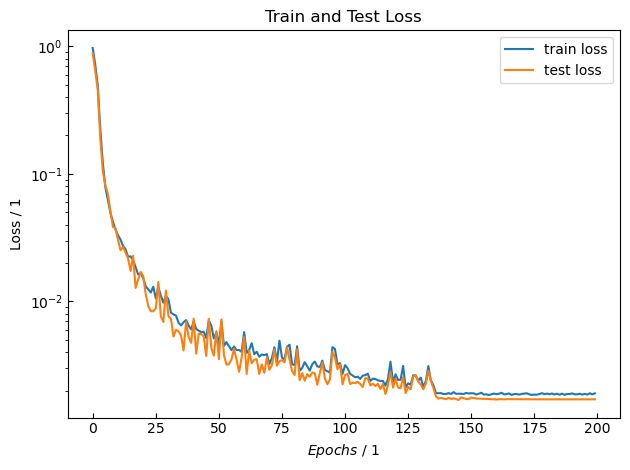

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9989962903769708 , R^2(NH3) = 0.9972438461021034
Test Dataset: R^2(H2) = 0.998922967639626 , R^2(NH3) = 0.997522228545568
Max Error Training: |x_H2 - x_H2,pred| = 0.033015992301360375 , |x_NH3 - x_NH3,pred| = 0.0223539666338316
Max Error Test: |x_H2 - x_H2,pred| = 0.019628566282952953 , |x_NH3 - x_NH3,pred| = 0.01772332771541643


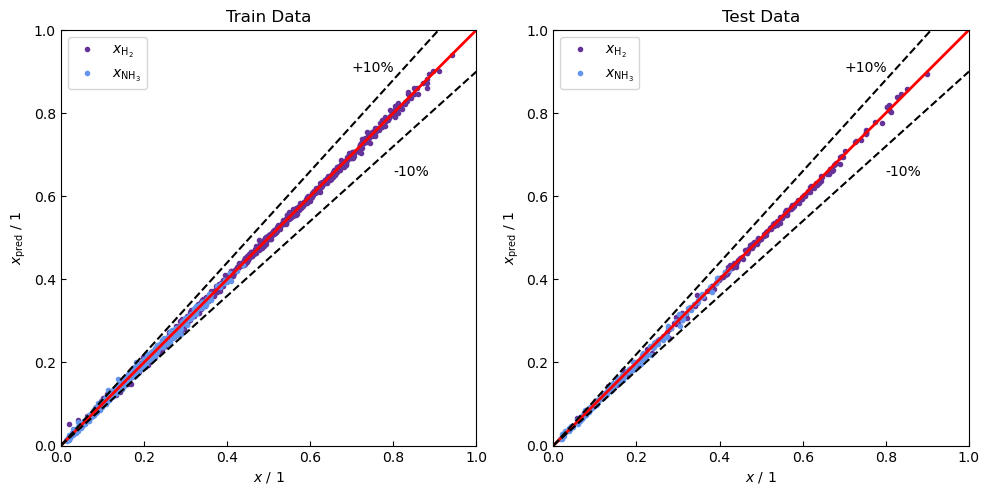

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

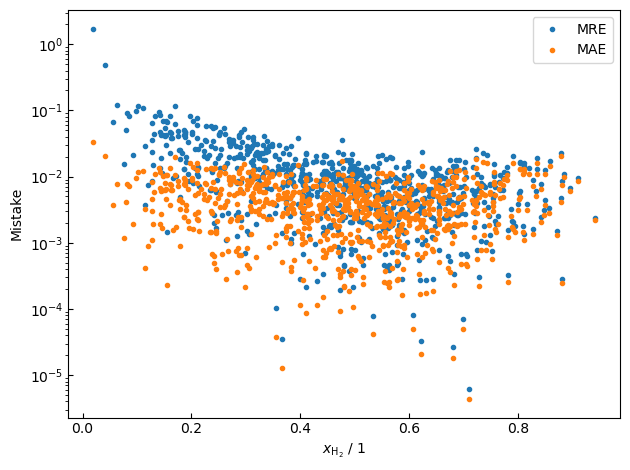

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

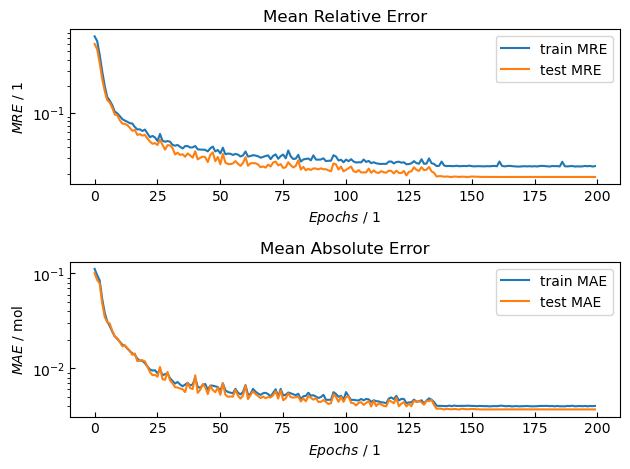

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

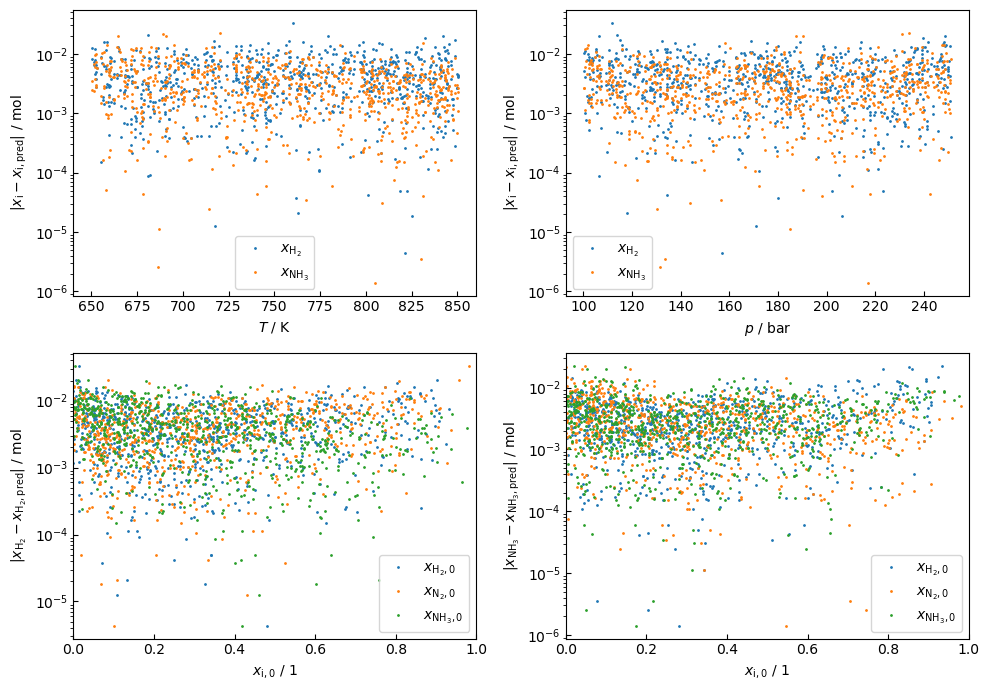

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

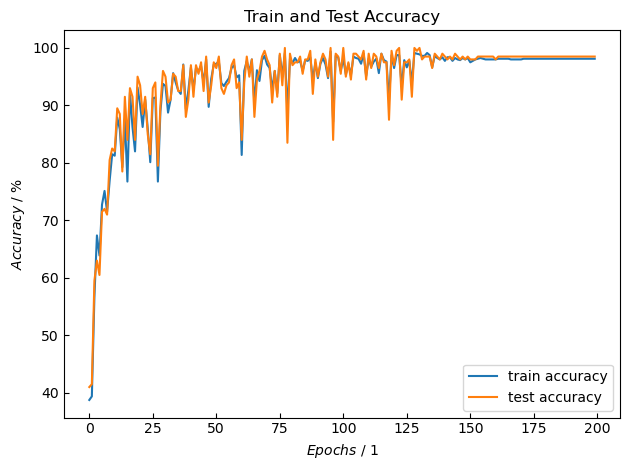

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [16]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.015625 s


#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-1.5203e+00,  1.7218e+00,  6.4117e-01, -9.9112e-01,  3.8376e-01],
        [-1.2683e+00, -1.0797e+00,  3.0313e-01, -6.5160e-01,  3.6850e-01],
        [ 1.0378e+00, -2.1129e-01, -1.0994e+00,  1.8913e+00, -8.5414e-01],
        [-1.1637e+00, -9.0495e-01,  6.9587e-01, -1.3622e+00,  7.0937e-01],
        [ 1.2191e+00, -7.4080e-02, -7.8744e-01,  1.9417e+00, -1.2118e+00],
        [ 1.1866e+00,  5.4906e-01, -1.0935e+00,  6.7918e-01,  3.7893e-01],
        [-2.4182e-01,  5.0711e-01,  6.6396e-01, -7.4927e-01,  1.1421e-01],
        [-9.9083e-01, -1.5584e+00,  1.0047e+00, -1.6559e-01, -8.1676e-01],
        [ 1.3420e+00,  1.0437e+00, -7.5648e-01,  5.5882e-01,  1.7124e-01],
        [ 4.0448e-01,  1.6978e+00, -8.8078e-01,  1.9873e+00, -1.1668e+00],
        [ 8.7705e-01,  2.3089e-01,  4.1486e-01, -1.8945e-01, -2.1351e-01],
        [ 7.1343e-01, -4.8503e-01,  8.9782e-01,  4.7236e-01, -1.3639e+00],
        [ 2.5868e-01,  1.2944e+00,  7.9430e-01,  1.5535e-01, -9.3828e-01],
        [-1.2474e+00, -1.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-0.4405,  0.1351,  0.3425, -0.4864,  0.1660],
         [ 0.3872, -0.1181,  0.4553, -0.1469,  0.3116],
         [-0.0605,  0.0276,  0.5308, -0.6918,  0.0369],
         [ 0.6792, -0.3591, -0.2353,  0.0223, -0.1710],
         [ 0.0085,  0.0190, -0.1088,  0.5626, -0.2272]], requires_grad=True),
 Parameter containing:
 tensor([ 0.6268,  1.0036, -1.6320,  0.2824, -0.2694], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1790, -0.3732, -0.1045, -0.1597, -0.3414],
         [ 0.4295, -0.2928, -0.8917, -0.4827, -0.1431],
         [ 0.0322,  0.6251,  1.3533,  0.6172,  0.9933],
         [ 0.4816, -1.2200, -0.5220, -0.3554,  0.2778],
         [ 0.3791,  0.5169,  0.5417,  0.1109, -0.4712]], requires_grad=True),
 Parameter containing:
 tensor([-0.1426,  0.1393,  0.0013,  0.3267,  0.5196], requires_grad=True),
 Parameter containing:
 tensor([[ 0.5884, -0.0210,  0.2818, -0.3114,  1.0498],
         [ 0.3218,  0.9419, -0.5691,  0.7254,  0.2046],
         [ 0.4161

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.8254, 0.4668, 0.0173, 0.9641, 0.7870],
        [0.5234, 0.1782, 0.1088, 0.5598, 0.5526]])
tensor([[ 0.0533, -0.6025],
        [ 0.1792, -0.3873]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-0.4501,  1.1754, -1.3832,  2.5029, -1.2006],
        [ 0.6063, -1.5646, -0.3380, -0.3266,  0.6656],
        [ 1.5276,  0.1648, -0.0329, -0.7492,  0.7981],
        [ 0.9127, -0.7277,  0.0567,  0.0069, -0.0627],
        [ 0.4150, -1.3435, -1.2563,  2.2465, -1.0631],
        [-0.3246,  0.6992,  0.4483,  0.7386, -1.1949],
        [-0.1950,  1.3053, -0.2078,  1.2658, -1.0898],
        [ 1.4035,  0.5941, -0.6303, -0.9479,  1.5874],
        [-0.6397,  1.1531,  0.5814,  0.0047, -0.5754],
        [ 1.1035,  0.3839,  0.2508, -1.2986,  1.0812],
        [ 0.8175,  0.6694, -1.0789, -0.1975,  1.2607],
        [-1.2439,  0.6757, -0.7309, -1.0059,  1.7455],
        [ 1.2629, -1.3835, -0.4164, -0.0921,  0.5028],
        [ 0.8075,  0.8243,  0.4517, -0.9248,  0.5020],
        [-1.0127,  0.6805, -1.1289,  0.7240,  0.3679],
        [ 1.2952, -0.3962,  2.5526, -1.3787, -1.0960],
        [-0.3506, -0.0350, -0.0064, -0.3655,  0.3799],
        [-1.2474, -1.0619, -0.8580,  1.4754, -0.6659],
        [-

#### Histogramme Verteilung von $xi$ und $x{_i}$

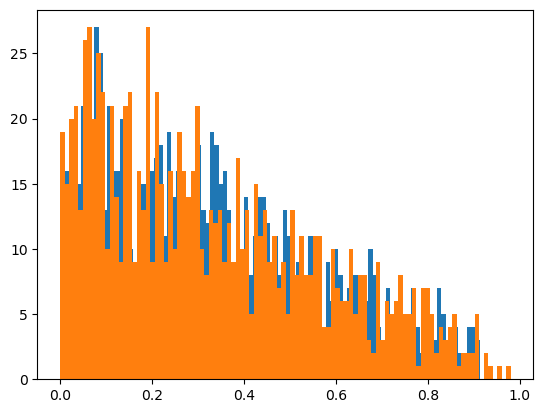

In [22]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [23]:
# torch.save(net.state_dict(),'data/models/ann_005_039.pth')
# np.savez('data/models/params_005_039.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)